In [1]:
!pip install transformers datasets --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you

In [2]:
import math
import os
import pickle
import re
from dataclasses import dataclass

import datasets
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, precision_recall_fscore_support)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tqdm.notebook import tqdm
from transformers import (AdamW, BertForSequenceClassification, BertTokenizer,
                          DataCollatorWithPadding,
                          get_linear_schedule_with_warmup)

datasets.logging.set_verbosity_error()

In [3]:
def load_data():
    no_theme = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/NoThemeTweets.csv',
        index_col=0)
    # the `type` column will be important in the future to stratify the splits
    no_theme['type'] = 'no_theme-'

    with_theme = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/TweetsWithTheme.csv',
        index_col=0)
    with_theme['type'] = 'with_theme-'

    data = pd.concat([no_theme, with_theme])
    data['type'] = data['type'] + data['sentiment']
    # Remove duplicate tweets
    data = data[~data.index.duplicated(keep='first')]

    return data

data = load_data()
data

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-8671c1380e8f>", line 20, in <cell line: 20>
    data = load_data()
  File "<ipython-input-3-8671c1380e8f>", line 2, in load_data
    no_theme = pd.read_csv(
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 912, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 583, in _read
    return parser.read(nrows)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1704, in read
    ) = self._engine.read(  # type: ignore[attr-defined]
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/c_parser_wrapper.py", line 234, in read
    chunks = self._reader.read_low_memory(nrows)
  File "pandas/_libs/parsers.pyx", line 8

TypeError: object of type 'NoneType' has no len()

In [14]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tweets_processed.csv")
data.drop(columns=["type"], inplace=True)
data

,tweet_text,sentiment
0,14 ir,Positivo
1,like dei época,Positivo
2,queria conseguir comer alguma coisa pra poder ...,Positivo
3,d lindo dia,Positivo
4,pq pr jeito!!é oferta ha q aproveitar :p,Positivo
...,...,...
836061,concorrent pronta tudo :p love on top loveonto...,Positivo
836062,falei pensando conectar governo outro acabei e...,Positivo
836063,comecei isentao pesquisei bastant baixei mont ...,Positivo
836064,coisa trist amiga defendendo boçal fascista merda,Negativo


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836066 entries, 0 to 836065
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   tweet_text  831535 non-null  object
 1   sentiment   836066 non-null  object
dtypes: object(2)
memory usage: 12.8+ MB


In [16]:
sentiments = data.sentiment.value_counts()
print('Class ratio:', sentiments['Positivo']/sentiments['Negativo'])
sentiments

Class ratio: 0.5291866868835038


sentiment
Negativo    546739
Positivo    289327
Name: count, dtype: int64

In [17]:
def create_splits(data):
    test_validation_size = int(0.01*data.shape[0])
    train_validation, test = train_test_split(data, test_size=test_validation_size, random_state=42)
    train, validation = train_test_split(train_validation, test_size=test_validation_size, random_state=42)
    return train, validation, test
train, validation, test = create_splits(data)
print('Training samples:  ', train.shape[0])
print('Validation samples:', validation.shape[0])
print('Test samples:      ', test.shape[0])

Training samples:   819346
Validation samples: 8360
Test samples:       8360


In [56]:
def build_dataset(tokenizer, splits):
    train, validation, test = splits
    # I could create the dataset directly from pandas, but I will save and load from disk so Datasets com cache it
    # on disk. This is specially useful when you have a very large dataset that does not fit in memory, which is not
    # the case, but I will leave here this way as a demonstration.
    train.to_csv('train_split.csv')
    validation.to_csv('validation_split.csv')
    test.to_csv('test_split.csv')
    dataset = datasets.load_dataset('csv', data_files={'train': 'train_split.csv',
                                                       'validation':'validation_split.csv',
                                                       'test': 'test_split.csv'})
    dataset = dataset.map(lambda examples: tokenizer([str(tweet_text) for tweet_text in examples['tweet_text']]), batched=True)
    dataset = dataset.map(lambda example: {'labels': 1 if example['sentiment'] == 'Positivo' else 0}, batched=False)
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [57]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
dataset = build_dataset(tokenizer, (train, validation, test))

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/819346 [00:00<?, ? examples/s]

Map:   0%|          | 0/8360 [00:00<?, ? examples/s]

Map:   0%|          | 0/8360 [00:00<?, ? examples/s]

Map:   0%|          | 0/819346 [00:00<?, ? examples/s]

Map:   0%|          | 0/8360 [00:00<?, ? examples/s]

Map:   0%|          | 0/8360 [00:00<?, ? examples/s]

In [71]:
dataset = dataset.remove_columns('Unnamed: 0')
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_text', 'sentiment', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 819346
    })
    validation: Dataset({
        features: ['tweet_text', 'sentiment', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8360
    })
    test: Dataset({
        features: ['tweet_text', 'sentiment', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8360
    })
})

In [4]:
# dataset.save_to_disk('/content/drive/MyDrive/Colab Notebooks/Sentimental_Analysis/dataset_processed')
dataset = datasets.load_from_disk("/content/drive/MyDrive/Colab Notebooks/Sentimental_Analysis/dataset_processed")

In [5]:
def compute_metrics(preds, labels):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def send_inputs_to_device(inputs, device):
    return {key:tensor.to(device) for key, tensor in inputs.items()}

In [6]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Sentimental_Analysis/epoch2'

In [7]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))
validation_loader = torch.utils.data.DataLoader(dataset['validation'], batch_size=32, collate_fn=DataCollatorWithPadding(tokenizer))
test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=32, collate_fn=DataCollatorWithPadding(tokenizer))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [8]:
num_epochs = 1
num_warmup_steps = 5000

model = BertForSequenceClassification.from_pretrained(model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.train().to(device)

optimizer = AdamW(model.parameters(), lr=5e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_epochs*len(train_loader))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
def predict(model, validation_loader, device):
    with torch.no_grad():
        model.eval()
        preds = []
        labels = []
        validation_losses = []
        for inputs in validation_loader:
            labels.append(inputs['labels'].numpy())

            inputs = send_inputs_to_device(inputs, device)
            loss, scores = model(**inputs)[:2]
            validation_losses.append(loss.cpu().item())

            _, classifications = torch.max(scores, 1)
            preds.append(classifications.cpu().numpy())
        model.train()
    return np.concatenate(preds), np.concatenate(labels)


In [12]:
preds, labels = predict(model, test_loader, device)
metrics = compute_metrics(preds, labels)
print(metrics)

{'accuracy': 0.8570574162679426, 'f1': 0.7770938257787726, 'precision': 0.8686405337781484, 'recall': 0.7030037124535943}


In [38]:
df = pd.read_csv('Tweet_processed.csv')
data = df[['new_comments']]
data=data.dropna()
data

,new_comments
0,assim tá conta avon tá 19.00
1,vale nada comprei joy
2,gostei
3,legal 👍
4,bom preso
...,...
110213,veze demora
110214,vendo aqui joy
110215,gosto desta marca bom demai valeu atenção ...
110216,ju havan barato


In [39]:
def build_test_dataset(data,tokenizer,file_name):
    data = data.to_csv(file_name)
    # I could create the dataset directly from pandas, but I will save and load from disk so Datasets com cache it
    # on disk. This is specially useful when you have a very large dataset that does not fit in memory, which is not
    # the case, but I will leave here this way as a demonstration.
    dataset = datasets.load_dataset('csv', data_files={'test': file_name})
    dataset = dataset.map(lambda examples: tokenizer(examples['new_comments']), batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask'])
    return dataset


In [40]:
test_dataset = build_test_dataset(data,tokenizer,'Comment_test.csv')

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/109458 [00:00<?, ? examples/s]

In [49]:
test_dataset

DatasetDict({
    test: Dataset({
        features: ['new_comments', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 109458
    })
})

In [46]:
test_dataset = test_dataset.remove_columns('Unnamed: 0')
test_loader = torch.utils.data.DataLoader(test_dataset['test'], batch_size=32, collate_fn=DataCollatorWithPadding(tokenizer))

In [53]:
def only_predict(model, validation_loader, device):
    with torch.no_grad():
        model.eval()
        preds = []
        for inputs in validation_loader:
            inputs = send_inputs_to_device(inputs, device)
            outputs = model(**inputs)

            # Access the logits from the model output
            scores = outputs.logits

            _, classifications = torch.max(scores, 1)
            preds.append(classifications.cpu().numpy())
        model.train()
    return np.concatenate(preds)

preds = only_predict(model, test_loader, device)

In [54]:

preds

array([0, 0, 1, ..., 1, 0, 0])

In [56]:
df = df.dropna()
df

,t1.media_id,comment_content,sum_pay_ord_cnt,sum_item_ck_cnt,sum_item_sw_cnt,cvr,ctr,interaction,new_comments
0,150103797746958,mesmo assim tá em conta na Avon tá 19.00,2,420,220153,0.004762,0.001908,342,assim tá conta avon tá 19.00
1,150103797746958,vale nada. Já comprei [joy],2,420,220153,0.004762,0.001908,24,vale nada comprei joy
2,150103797746958,gostei,2,420,220153,0.004762,0.001908,85,gostei
3,150103797746958,legal 👍,2,420,220153,0.004762,0.001908,80,legal 👍
4,150103797746958,muito bom preso,2,420,220153,0.004762,0.001908,38,bom preso
...,...,...,...,...,...,...,...,...,...
110213,150106310884901,As vezes demora um,13,2398,297240,0.005421,0.008068,24,veze demora
110214,150106310884901,Mais eu vendo aqui [joy],13,2398,297240,0.005421,0.008068,11,vendo aqui joy
110215,150106310884901,eu gosto muito desta marca e bom demais vale...,13,2398,297240,0.005421,0.008068,10,gosto desta marca bom demai valeu atenção ...
110216,150106310884901,Ju na Havan é mais barato,13,2398,297240,0.005421,0.008068,27,ju havan barato


In [57]:
df['label'] = preds

<ipython-input-57-b6539c4a2c7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = preds


,t1.media_id,comment_content,sum_pay_ord_cnt,sum_item_ck_cnt,sum_item_sw_cnt,cvr,ctr,interaction,new_comments,label
0,150103797746958,mesmo assim tá em conta na Avon tá 19.00,2,420,220153,0.004762,0.001908,342,assim tá conta avon tá 19.00,0
1,150103797746958,vale nada. Já comprei [joy],2,420,220153,0.004762,0.001908,24,vale nada comprei joy,0
2,150103797746958,gostei,2,420,220153,0.004762,0.001908,85,gostei,1
3,150103797746958,legal 👍,2,420,220153,0.004762,0.001908,80,legal 👍,1
4,150103797746958,muito bom preso,2,420,220153,0.004762,0.001908,38,bom preso,1
...,...,...,...,...,...,...,...,...,...,...
110213,150106310884901,As vezes demora um,13,2398,297240,0.005421,0.008068,24,veze demora,0
110214,150106310884901,Mais eu vendo aqui [joy],13,2398,297240,0.005421,0.008068,11,vendo aqui joy,0
110215,150106310884901,eu gosto muito desta marca e bom demais vale...,13,2398,297240,0.005421,0.008068,10,gosto desta marca bom demai valeu atenção ...,1
110216,150106310884901,Ju na Havan é mais barato,13,2398,297240,0.005421,0.008068,27,ju havan barato,0


In [111]:
df = df[df['sum_pay_ord_cnt']>5]
df = df.groupby('t1.media_id').filter(lambda x: len(x) > 10)
df['weighted_label'] = df['interaction']*df['label']
df['opm'] = df['ctr']*df['cvr']*1000
df

,t1.media_id,comment_content,sum_pay_ord_cnt,sum_item_ck_cnt,sum_item_sw_cnt,cvr,ctr,interaction,new_comments,label,opm,weighted_label
107,150104363604157,Que susto achei que era outra coisa. 😂😂,9,252,74938,0.035714,0.003363,411,susto achei outra coisa 😂 😂,0,0.120099,0
108,150104363604157,Estar esgotado,9,252,74938,0.035714,0.003363,10,esgotado,0,0.120099,0
109,150104363604157,amei,9,252,74938,0.035714,0.003363,10,amei,1,0.120099,10
110,150104363604157,o aparelho nao funcionou textei de todas as fo...,9,252,74938,0.035714,0.003363,10,aparelho nao funcion textei toda forma nao deu...,0,0.120099,0
111,150104363604157,interessante o produto,9,252,74938,0.035714,0.003363,10,interessant produto,1,0.120099,10
...,...,...,...,...,...,...,...,...,...,...,...,...
110183,150106119765672,eu cago desse jeito.,261,31443,5793802,0.008301,0.005427,748,cago dess jeito,0,0.045048,0
110184,150106119765672,eca moço [joy][joy][joy][joy][joy],261,31443,5793802,0.008301,0.005427,123,eca moço joy][joy][joy][joy][joy,0,0.045048,0
110185,150106119765672,emuito top10 gostei muito,261,31443,5793802,0.008301,0.005427,10,emuito top10 gostei,1,0.045048,10
110186,150106119765672,mentira não tem na loja do Kwai [sunglasses],261,31443,5793802,0.008301,0.005427,60,mentira loja kwai sunglass,0,0.045048,0


In [112]:
# Calculate the average label and ctr for each distinct media_id
average_metrics = df.groupby('t1.media_id').agg({
    'weighted_label': 'sum',
    'interaction':'sum',
    'ctr': 'mean',
    'cvr': 'mean',
    'opm': 'mean'
}).reset_index()


average_metrics['label'] = average_metrics['weighted_label']/average_metrics['interaction']

In [113]:
average_metrics

,t1.media_id,weighted_label,interaction,ctr,cvr,opm,label
0,150100596391131,417,1259,0.004535,0.001010,0.004580,0.331215
1,150100643681922,524,708,0.007082,0.007987,0.056563,0.740113
2,150100645233121,566,1237,0.006310,0.003167,0.019985,0.457559
3,150101563789251,4035,9202,0.008305,0.001045,0.008675,0.438492
4,150102267266521,2056,5456,0.008260,0.001486,0.012275,0.376833
...,...,...,...,...,...,...,...
1903,150106360882657,405,940,0.007971,0.017336,0.138191,0.430851
1904,150106363394852,262,1166,0.004744,0.026778,0.127043,0.224700
1905,150106368225547,183,306,0.003393,0.009071,0.030781,0.598039
1906,150106375757880,173,508,0.012435,0.005172,0.064317,0.340551


<Axes: xlabel='label', ylabel='Density'>

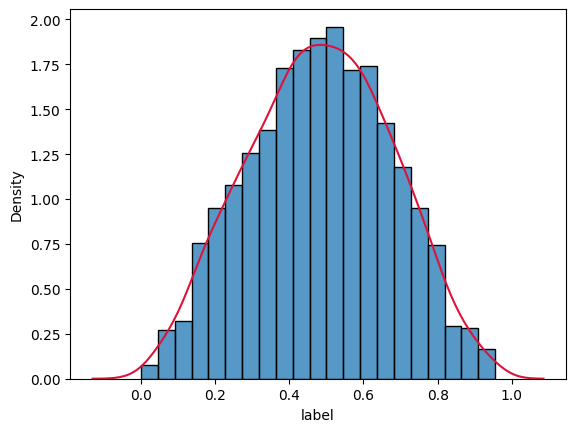

In [98]:
import seaborn as sns
sns.histplot(x = average_metrics['label'],stat = 'density')
sns.kdeplot(x = average_metrics['label'], color='crimson')

In [99]:
average_metrics['label'].mean()

0.4839481792040191

In [100]:

import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.stats as stats
import seaborn as sns
import math
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms

import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


In [114]:
# 2.d
data = average_metrics
ols_mod = smf.ols(formula='ctr ~ label', data=data)
ols_fit = ols_mod.fit()
# remove outliers base on cooks_distance
thresh = 4/len(ols_fit.fittedvalues)
cooks_distance = ols_fit.get_influence().cooks_distance[0]
data_new = data[cooks_distance < thresh]
# 3. run the original multilinear regression
ols_mod1 = smf.ols(formula='ctr ~ label', data=data_new)
ols_fit1 = ols_mod1.fit()
print(ols_fit1.summary())

                            OLS Regression Results                            
Dep. Variable:                    ctr   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     37.34
Date:                Fri, 28 Jun 2024   Prob (F-statistic):           1.21e-09
Time:                        11:51:33   Log-Likelihood:                 8905.9
No. Observations:                1826   AIC:                        -1.781e+04
Df Residuals:                    1824   BIC:                        -1.780e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0054      0.000     46.239      0.0

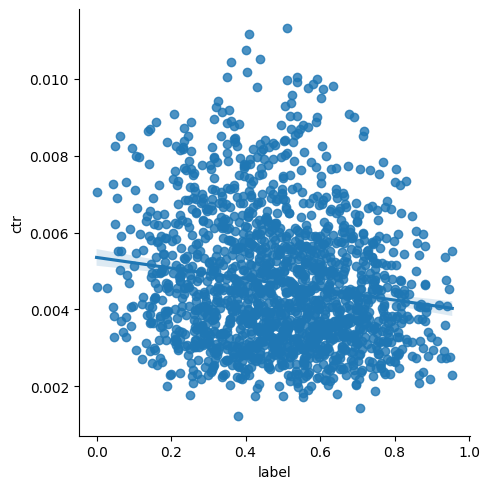

In [102]:
sns.lmplot(data_new,x = 'label',y = 'ctr')

In [103]:
# 2.d
data = average_metrics
ols_mod = smf.ols(formula='cvr ~ label', data=data)
ols_fit = ols_mod.fit()
# remove outliers base on cooks_distance
thresh = 4/len(ols_fit.fittedvalues)
cooks_distance = ols_fit.get_influence().cooks_distance[0]
data_new = data[cooks_distance < thresh]
# 3. run the original multilinear regression
ols_mod1 = smf.ols(formula='cvr ~ label', data=data_new)
ols_fit1 = ols_mod1.fit()
print(ols_fit1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cvr   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     104.8
Date:                Fri, 28 Jun 2024   Prob (F-statistic):           6.73e-24
Time:                        11:44:35   Log-Likelihood:                 6580.9
No. Observations:                1660   AIC:                        -1.316e+04
Df Residuals:                    1658   BIC:                        -1.315e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0050      0.000     16.294      0.0

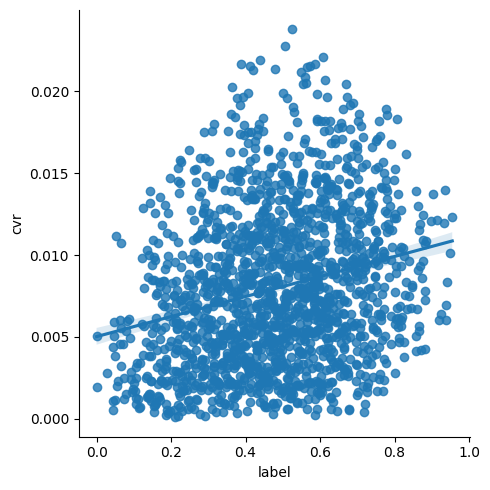

In [104]:
sns.lmplot(data_new,x = 'label',y = 'cvr')

In [106]:
df = pd.read_csv('Tweet_processed.csv')
df = df.dropna()
df['label'] = preds
df

,t1.media_id,comment_content,sum_pay_ord_cnt,sum_item_ck_cnt,sum_item_sw_cnt,cvr,ctr,interaction,new_comments,label
0,150103797746958,mesmo assim tá em conta na Avon tá 19.00,2,420,220153,0.004762,0.001908,342,assim tá conta avon tá 19.00,0
1,150103797746958,vale nada. Já comprei [joy],2,420,220153,0.004762,0.001908,24,vale nada comprei joy,0
2,150103797746958,gostei,2,420,220153,0.004762,0.001908,85,gostei,1
3,150103797746958,legal 👍,2,420,220153,0.004762,0.001908,80,legal 👍,1
4,150103797746958,muito bom preso,2,420,220153,0.004762,0.001908,38,bom preso,1
...,...,...,...,...,...,...,...,...,...,...
110213,150106310884901,As vezes demora um,13,2398,297240,0.005421,0.008068,24,veze demora,0
110214,150106310884901,Mais eu vendo aqui [joy],13,2398,297240,0.005421,0.008068,11,vendo aqui joy,0
110215,150106310884901,eu gosto muito desta marca e bom demais vale...,13,2398,297240,0.005421,0.008068,10,gosto desta marca bom demai valeu atenção ...,1
110216,150106310884901,Ju na Havan é mais barato,13,2398,297240,0.005421,0.008068,27,ju havan barato,0


In [107]:
csv_filename = "Comment_Label.csv"
df.to_csv(csv_filename, index=False)

In [108]:
df['opm'] = df['ctr']*df['cvr']*1000
df

,t1.media_id,comment_content,sum_pay_ord_cnt,sum_item_ck_cnt,sum_item_sw_cnt,cvr,ctr,interaction,new_comments,label,opm
0,150103797746958,mesmo assim tá em conta na Avon tá 19.00,2,420,220153,0.004762,0.001908,342,assim tá conta avon tá 19.00,0,0.009085
1,150103797746958,vale nada. Já comprei [joy],2,420,220153,0.004762,0.001908,24,vale nada comprei joy,0,0.009085
2,150103797746958,gostei,2,420,220153,0.004762,0.001908,85,gostei,1,0.009085
3,150103797746958,legal 👍,2,420,220153,0.004762,0.001908,80,legal 👍,1,0.009085
4,150103797746958,muito bom preso,2,420,220153,0.004762,0.001908,38,bom preso,1,0.009085
...,...,...,...,...,...,...,...,...,...,...,...
110213,150106310884901,As vezes demora um,13,2398,297240,0.005421,0.008068,24,veze demora,0,0.043736
110214,150106310884901,Mais eu vendo aqui [joy],13,2398,297240,0.005421,0.008068,11,vendo aqui joy,0,0.043736
110215,150106310884901,eu gosto muito desta marca e bom demais vale...,13,2398,297240,0.005421,0.008068,10,gosto desta marca bom demai valeu atenção ...,1,0.043736
110216,150106310884901,Ju na Havan é mais barato,13,2398,297240,0.005421,0.008068,27,ju havan barato,0,0.043736


In [116]:
# 2.d
data = average_metrics
ols_mod = smf.ols(formula='opm ~ label', data=data)
ols_fit = ols_mod.fit()
# remove outliers base on cooks_distance
thresh = 4/len(ols_fit.fittedvalues)
cooks_distance = ols_fit.get_influence().cooks_distance[0]
data_new = data[cooks_distance < thresh]
# 3. run the original multilinear regression
ols_mod1 = smf.ols(formula='opm ~ label', data=data_new)
ols_fit1 = ols_mod1.fit()
print(ols_fit1.summary())

                            OLS Regression Results                            
Dep. Variable:                    opm   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     48.14
Date:                Fri, 28 Jun 2024   Prob (F-statistic):           5.42e-12
Time:                        11:51:52   Log-Likelihood:                 4374.1
No. Observations:                1900   AIC:                            -8744.
Df Residuals:                    1898   BIC:                            -8733.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0249      0.001     16.885      0.0